> **Student Names and IDs**:
>
> - Student 1, ID1 (Replace this item with your first and last name and student ID number.
Add more items like this as needed, including the `> -` characters at the beginning,
which generate the indent and the bullet.)

# Homework 6

## Part 1: Exam-Style Questions

### Problem 1.1

Compute $A$ and $\mathbf{b}$.

### Answer

### Problem 1.2

Does the feature at $\mathbf{x}_I$ suffer from the aperture problem? Briefly justify your answer.

### Answer

### Problem 1.3

Give the minimum-norm solution $\mathbf{x}_0$ to the linear system

$$
A\mathbf{x} = \mathbf{b}\;.
$$

### Answer

### Problem 1.4

Assume that further iterations of the Lucas-Kanade algorithm do not change the solution $\mathbf{x}_0$ much. Does your answer to the previous question imply that the image motion between $I$ and $J$ at $\mathbf{x}_I$ is approximately horizontal? Briefly justify your answer.

### Answer

### Problem 1.5

[Questions from now on no longer pertain to the scenario above.]

Give the simplest example you can think of of two rotation matrices $R_1$ and $R_2$ in $\mathbb{R}^3$ that commute with each other. Two matrices $A$ and $B$ commute if $AB = BA$. There is no need to prove the correctness of your answer.

### Answer

### Problem 1.6

Give the simplest example you can think of of two rotation matrices $R_1$ and $R_2$ in $\mathbb{R}^3$ that do _not_ commute with each other.

### Answer

### Problem 1.7

A certain camera has the following intrinsic parameters:

* A 10 mm focal distance
* Rectangular pixels, 2.5 micron wide and 2 micron tall (one mm is 1000 micron)
* A camera sensor with 4000 pixels horizontally and 3000 vertically
* The principal point is at image point $\boldsymbol{\pi} = (2000, 1500)$ pixels (horizontal, vertical)
* No distortion

The world reference system is the same as the camera's canonical reference system, except that the units for the axes are in centimeters. A point $\mathbf{X}$ has coordinates (-20, 10, 100) centimeters in the world reference system.

Give the coordinates in the _pixel image_ reference system of the projection $\boldsymbol{\xi}$ of $\mathbf{X}$. Show your calculations.

[The pixel image reference system measures image coordinates in pixels, and its origin is in the upper left corner of the image.]


### Answer

### Problem 1.8

This and the subsequent two problems refer to a camera pair with the following essential matrix:

$$
E = \left[\begin{array}{rrr}
0 & 0 & 0\\
0 & 0 & - 1\\
0 & 1 & 0
\end{array} \right]
$$

For the same camera pair as in problem 1.8, give one possible value for the unit-norm vector $\mathbf{t}$ that points from the first camera to the second and for the rotation matrix $R$ between the two cameras. Both $\mathbf{t}$ and $R$ are expressed in first-camera coordinates. Justify your answer briefly.

[Hint: Think, do not calculate. What does $[\mathbf{t}]_{\times}$ look like?]

### Answer

### Problem 1.9

For the same camera pair as in problem 1.8, what is the angle between the optical axes of the two cameras? No need to justify your answer, if you are sure about it.

### Answer

### Problem 1.10

For the same camera pair as in problem 1.8, a point in the second image has coordinates

$$
\mathbf{b} = \left[\begin{array}{c} 0.5\\1\\1 \end{array} \right]
$$

in the canonical _camera_ reference system (units are focal distances). Write the equation of the epipolar line of $\mathbf{b}$ in the canonical _image_ reference system of the first camera. Show your derivation.

[Remember that the canonical image coordinates of a point are the same as its first two canonical camera coordinates.]

### Answer

## Part 2: Window Tracking

Restarting frame reader for freeThrow/img


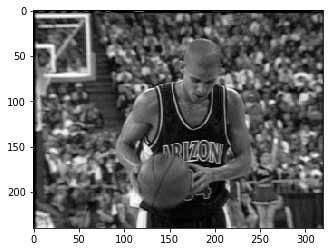

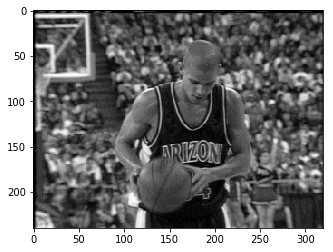

In [17]:
from urllib.request import urlopen
from shutil import copyfileobj
from tempfile import NamedTemporaryFile as namedTempFile
from imageio import imread
from zipfile import ZipFile
from os.path import exists

def frameReader(basename, first, last, fmt = r'{}{:03d}.pgm'):
    print('Restarting frame reader for', basename)
    for f in range(first, last+1):
        filename = fmt.format(basename, f)
        if f % 10 is 0: print(f, end=' ')
        yield imread(filename).astype(float) / 255.0
    
def freeThrowReader():
    url = 'https://www2.cs.duke.edu/courses/spring19/compsci527/homework/6/'
    basename = 'freeThrow'
    zipname = basename + '.zip'
    if not exists(basename):
        print('Retrieving', zipname, 'from', url)
        with urlopen(url + zipname) as response:
            with namedTempFile(delete=False) as tmpFile:
                copyfileobj(response, tmpFile)
        with ZipFile(tmpFile.name, 'r') as zip:
            zip.extractall()
        print('Stored video in the local data directory', basename)
    return frameReader(basename + '/img', 2, 129)

from matplotlib import pyplot as plt
%matplotlib inline

# Show a couple of frames
ftr = freeThrowReader()
for i in range(2):
    frame = next(ftr)
    plt.imshow(frame, cmap=plt.cm.gray)
    plt.show()

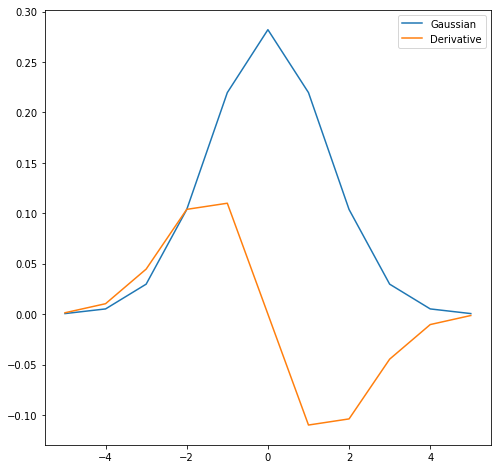

In [25]:
import numpy as np

def Gauss(hWin):
    winSize, sigma = 2 * hWin + 1, hWin / 2.5
    x = np.linspace(-hWin, hWin, winSize)
    g = np.exp(- np.power(x, 2) / np.power(sigma, 2))
    ramp = -x
    d = ramp * g
    return g / np.sum(g), d / np.dot(ramp, d), x   

hGaussWin = 5
g, d, x = Gauss(hGaussWin)
plt.figure(figsize=(8, 8))
plt.plot(x, g, label='Gaussian')
plt.plot(x, d, label='Derivative')
plt.legend()
plt.show()


In [27]:
def row(x):
    assert x.ndim == 1, 'Input must be a 1-dimensional array'
    return np.expand_dims(x, 0)

def column(x):
    assert x.ndim == 1, 'Input must be a 1-dimensional array'
    return np.expand_dims(x, 1)

from scipy.signal import convolve2d as conv

def gradient(img, hWin):
    g, d, _ = Gauss(hWin)
    gr = conv(conv(img, row(g), 'same'), column(d), 'same')
    gc = conv(conv(img, row(d), 'same'), column(g), 'same')
    
    return (gr, gc)

from skimage.color import hsv2rgb

def colorCoding(x, y):
    z = x + 1j * y
    mag, ang = np.absolute(z), np.angle(z)
    mn, mx = np.min(mag), np.max(mag)
    hsv = np.zeros((*x.shape, 3), dtype=float)
    hsv[..., 0] = (ang + np.pi) / (2.0 * np.pi)
    hsv[..., 1] = (mag - mn) / mx
    hsv[..., 2] = 1.0
    return hsv2rgb(hsv)

# Display a color coding of the gradient of the last frame read
gr, gc = gradient(frame, hGaussWin)
plt.figure(figsize=(8, 8))
plt.imshow(colorCoding(gc, gr))
plt.title('color coding of input-frame gradient')
plt.show()

ImportError: cannot import name 'rgb2gray' from 'skimage.color' (/Users/Yiteng/anaconda3/lib/python3.7/site-packages/skimage/color/__init__.py)

In [28]:
parms = {}
parms['hGaussWin'] = 3
parms['hFeatureWin'] = 5
parms['lambdaPercentile'] = 90
parms['maxNFeatures'] = 1000
parms['minFeatureDistance'] = 5
parms['minStep'] = 0.01
parms['maxIterations'] = 30

### Problem 2.1

Write a function with header

    def lambdaMin(f, parms):
    
that takes a single frame `f` out of a video sequence and returns a floating-point image `lambda2` of the same size as `f`. The value of every pixel in `lambda2` is the smaller eigenvalue of the matrix $A_f$ defined in the class notes on window tracking. [Recall that the eigenvalue of a $2\times 2$ matrix can be computed in closed form, as shown in Algorithm 2 in the class notes on window tracking.]

Show your code and a binary image that is white wherever `lambda2 > lambda0` and black elsewhere. The image `f` for this experiment is the image `frame` defined earlier (the second frame returned by `freeThrowReader`). The threshold `lambda0` is the percentile of `lambda2` specified in `parms`.

Make your figure with `plt.figure(figsize=(8, 8))`. Give your figure a title that shows the value of `lambda0` with 5 digits after the decimal period.

### Answer

### Problem 2.2

In [5]:
def outside(p, shape, parms):
    margin = parms['hGaussWin'] + parms['hFeatureWin']
    out = p[0] < margin or p[0] > shape[0] - margin
    return out or p[1] < margin or p[1] > shape[1] - margin

Write a function with header

    def goodFeatures(img, parms):
    
that computes as many good features to track as possible by the algorithm described in the class notes. We are not asking to find the absolute maximum number of features: The greedy method described in the class notes will suffice.

Good features

* Have a value of `lambda2` greater than the percentile specified in `parms`
* Are at most `parms['maxNFeatures']` in number
* Are spaced at least `parms['minFeatureDistance']` apart
* Are not too close to the margins of `img`, as determined by `outside`

Show your code and the centers of the windows found in `frame` (same as earlier) superimposed as red crosses. Make your figure with `plt.figure(figsize=(8, 8))`.

Also state the number of features your code found (these will be fewer than `parms['maxNFeatures']`).

### Answer

### Problem 2.3

Write a function with header

    def lucasKanade(f, g, p, parms):

that implements the Lucas-Kanade algorithm as described in the class notes, and with the parameters specified in `parms`. The input arguments `f` and `g` are two consecutive frames of a video sequence, and `p` is a `numpy` array of shape `(2,)` that contains the row and column coordinates of the feature point (center of a feature window) in `f` to be tracked. The function returns a `numpy` array of shape `(2,)` that contains the row and column coordinates of the corresponding feature point in `g` (not the displacement).

Please keep in mind that the description given in Algorithm 1 on page 7 of the notes is only a conceptual trace. In Python, it is easier to look at the equations in section 2 of the notes, and implement those.

Show your code and the result of the test code given below. The code assumes that the file `data.pkl` provided with this assignment is in the same directory as this notebook.

### Answer

In [6]:
# Your code here

In [7]:
import pickle
try:
    with open('data.pkl', 'rb') as file:
        data = pickle.load(file)
    f, g, p, qTrue = data['f'], data['g'], data['p'], data['q']
    q = np.empty_like(qTrue)
    for k in range(p.shape[0]):
        q[k] = lucasKanade(f, g, p[k], parms)
    np.set_printoptions(precision=4, suppress=True)
    print('Tracking errors (in pixels):')
    print(q-qTrue)
    np.set_printoptions()
except NameError:
    pass

### Problem 2.4

Write a function with header

    def trackPoints(videoReader, parms):

that tracks all good features found in the first frame of the video generated by the reader, and with the given parameters. Your function should use your own `goodFeatures` and `lucasKanade`.

The output from `trackPoints` should be a list of lists. There is one inner list for each point found by `goodFeatures` in the first frame of the video. This inner list lists the coordinates of that point in every frame (as a `numpy` array), until the point is lost. When the point is lost, the corresponding list entry is `None`, and the list stops after that entry.

Show your code and display the results from the call

    tracks = trackPoints(freeThrowReader, parms)

To display the results, produce two images. The first one is the _fill pattern_ of the result. Let $m$ be the length of the longest list in `tracks`, and let `n` be the length of `tracks`. Then, the fill pattern is an $m\times n$ binary matrix whose entry $(i, j)$ is equal to 1 if feature $j$ was found in frame $i$ and 0 otherwise.

Display the fill pattern as an image, using the default color map for `imshow`.

The second image you produce is the first frame of the video sequence (with `cmap=plt.cm.gray`) with the tracks superimposed as red lines. Also plot a red circle (`'or'`) at the beginning of each track.

Draw each figure in a `plt.figure(figsize=(8, 8))`.

### Answer

### Problem 2.5

Comment on the results. Specifically:

* Why are there few features on the basketball player?

* Describe a few features that, although detected, are either lost very soon or are not tracked correctly. Why does that happen?

* What could one do to track more features over more frames?

### Answer